# LSTM Neural Network Fitting Analysis

## Preamble

The aim of this analysis is to develop a pipeline that consists of a LSTM Neural Network (LSTM NN) that given the opening stock price of a stock over the previous 40 days, can accurately predict the current opening stock price.  This project was inspired by the work done by Yacoub Ahmed that can be found here https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe.  The aim is while using his original LSTM NN as a starting point, is to improve it and then leverage it to create a simulation of some stock trading on a few automobile stocks.  In the interest of academic honesty, it must be noted that while we took our inspiration from Yacoub and used his original LSTM model, all code used here is original.

Note, in call cases where we train a LSTM NN, we have commented it out and replaced it with code that loads in the models from memory.  This is done to save the markers time from having to retrain the models.  Which I certainly do not recommend unless you have a GPU at your disposal.

In [1]:
# Reading in neccessary packages
from datetime import date, timedelta
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statsmodels.graphics.tsaplots import plot_acf

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
data = pd.read_csv('Data/ford.csv', index_col='Date')

## Check for Reasonable Predictor

To begin, we will build our model on Ford stock from January 1st, 2000 to November 17, 2020 (The day I am creating this).  Lets first as a formality check that the daily opening stock price is actually correlated to the previous days opening stock price.  To check this, we will create a plot of the sample correlation (ACF) below.  If we examine the AF plot below, we can clearly see that the opening price is highly correlated to the previous days opening stock price.  We can actually see this continues for many lags k.  Of course the reader may be wondering what we mean by lag k?  Let the opening stock price of ford be represented by the time series process ${Y_t}$.  The current days opening stock price we are interested in can be denated as $Y_t$.  Then in the plot below we can a high correlation between $Y_t$ and $Y_{t-k}$ where k is some integer k that denotes some number of units back in time.  For instance, from the plot below we can see that the sample ACF between $Y_t$ and $Y_{t-2}$ produces a sample ACF very close to 1.  Moving on, our conclusion from this plot is simply that the current opening stock price of Ford has a high correlation with its past opening stock prices.  Thus, it could be a strong predictor.  Lastly, the question remains how far back in the past to predict the current opening stock price.  That is many many past days should we use to predict the current day.  To choose this we arbitrarilty chose 4.

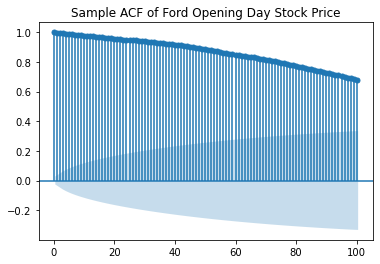

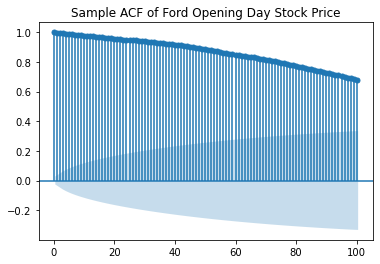

In [3]:
# CITATION: https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711
plot_acf(data['Open'], lags=100, title='Sample ACF of Ford Opening Day Stock Price')

# NOTE: for some reason this produces 2 of the same plot, it could not be removed.

## Set Up Code

The following few cells contain code that will be use to create, and evaluate the models

In [4]:
# This defines the numpy of days in the past we will use to predict the current price
LAG = 40

In [5]:
# Plots the results of a mode.
def plot(yHat, y, title):
    plt.plot(y)
    plt.plot(yHat)
    plt.legend(['Real', 'Predicted'])
    plt.title(title)
    plt.show()
    

In [6]:
# Calculates the MSE
def mse(x, y):
    preds = model.predict(x)
    preds = scaler.inverse_transform(preds)
    unscaled_yTest = scaler.inverse_transform(np.reshape(y, (-1, 1)))
    return np.mean(np.square(preds-unscaled_yTest)), preds, unscaled_yTest

In [7]:
# This function accepts the raw data and transforms it into the form required for the LSTM NN.  
# - It removes unneccessary columns
# - scales the data between 0 and 1
# - transforms into numpy arrays
def transform(df, n=40):
    df = pd.DataFrame(df['Open'])  # Removing all the other columns as we are only predicting if we should buy based on the opening stock price

    
    # Normalizing to 0-1 range
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df)
    df = pd.DataFrame(scaler.transform(df), columns=df.columns, index=pd.to_datetime(df.index))


    # Creating 40 columns that give the past 40 day opening stock price
    for i in range(1, n + 1):
        df[f'Open-{i}'] = df['Open'].shift(i)

    # Subsetting for the neccessary columns
    df = df.iloc[40:, 0:]

    # Splitting into training and testing data (test size is about last 2 years)
    dt = pd.to_datetime(date(2020, 11, 17) - timedelta(days=730))
    train = df[df.index < dt]
    test = df[df.index >= dt]


    # Splitting into appropriat x and y values
    xTrain = train.iloc[:, 1:]
    yTrain = train.iloc[:, 0]
    xTest = test.iloc[:, 1:]
    yTest = test.iloc[:, 0]

    # Converting to numpy arrays to feed into model
    xTrain = xTrain.to_numpy()
    yTrain = yTrain.to_numpy()
    xTest = xTest.to_numpy()
    yTest = yTest.to_numpy()

    # Reshaping to get correct form
    xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
    xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

    return xTrain, yTrain, xTest, yTest, scaler

In [8]:
def saveModel(model, name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # serialize model to JSON
    model_json = model.to_json()
    with open(f"{location}/{name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{location}/{name}.h5")
    print("Saved model to disk")

def loadModel(name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # load json and create model
    json_file = open(f"{location}/{name}.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(f"{location}/{name}.h5")
    return model
    print("Loaded model from disk")



In [9]:
xTrain, yTrain, xTest, yTest, scaler = transform(data, LAG)

In [10]:
# Setting the batch size for the model.
BATCH_SIZE = int(xTrain.shape[0]/3)
# BATCH_SIZE = xTrain.shape[0]

In [31]:
def modelTraining(epoch, batchSize, neuronsLSTM1=50,neuronsLSTM2=128, neuronsDense=64, learningRate=0.0005):
    with tf.device("gpu:0"):
        model = Sequential()
        model.add(LSTM(neuronsLSTM1,input_shape=(xTrain.shape[1],xTrain.shape[2])))
        # model.add(LSTM(neuronsLSTM1,input_shape=(xTrain.shape[1],xTrain.shape[2]), return_sequences=True))
        model.add(Dropout(0.2))
        # model.add(LSTM(neuronsLSTM2))
        # model.add(Dropout(0.2))
        model.add(Dense(neuronsDense))
        model.add(Activation('sigmoid'))
        model.add(Dense(1))
        model.add(Activation('linear'))
        opt = tf.keras.optimizers.Adam(lr=learningRate)
        model.compile(optimizer=opt, loss='mse')
        model.fit(xTrain,yTrain, batch_size=batchSize, epochs=epoch, shuffle=True)
    return model

## Model Tuning 1: Batch Size

Using our model as defined above, we explore the affect of batch sizes using of 10, 32(Default), 100, 500, 1000, 1500, and 2000.

In [34]:
batches = pd.DataFrame(columns=['batchSize', 'mseTrain','mseTest'])
for batchSize in [10]:
    model = modelTraining(2000, batchSize)
    mseTrain, yHat, y = mse(xTrain,yTrain)
    mseTest, yHat, y = mse(xTest,yTest)
    batches = batches.append({'batchSize':batchSize, 'mseTrain': mseTrain, 'mseTest':mseTest}, ignore_index=True)
    batches.to_csv('fordBatchTraining.csv')

    saveModel(model, f"fordBatchTraining{batchSize}", location='Data')

results = pd.read_csv('Data/fordBatchTraining.csv')
results
    


Epoch 1/2000
472/472 [==============================] - 4s 5ms/step - loss: 0.1136
Epoch 2/2000
472/472 [==============================] - 2s 5ms/step - loss: 0.0019
Epoch 3/2000
472/472 [==============================] - 2s 5ms/step - loss: 0.0018
Epoch 4/2000
472/472 [==============================] - 2s 5ms/step - loss: 0.0020
Epoch 5/2000
472/472 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 6/2000
472/472 [==============================] - 2s 5ms/step - loss: 0.0020
Epoch 7/2000
472/472 [==============================] - 2s 5ms/step - loss: 0.0016
Epoch 8/2000
472/472 [==============================] - 2s 5ms/step - loss: 0.0015
Epoch 9/2000
472/472 [==============================] - 2s 5ms/step - loss: 0.0017
Epoch 10/2000
472/472 [==============================] - 2s 5ms/step - loss: 0.0014
Epoch 11/2000
472/472 [==============================] - 2s 5ms/step - loss: 0.0017
Epoch 12/2000
472/472 [==============================] - 2s 5ms/step - loss: 0.0013
E

472/472 [==============================] - 2s 5ms/step - loss: 3.9434e-04
Epoch 96/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.1327e-04
Epoch 97/2000
472/472 [==============================] - 3s 6ms/step - loss: 4.6084e-04
Epoch 98/2000
472/472 [==============================] - 3s 6ms/step - loss: 4.8400e-04
Epoch 99/2000
472/472 [==============================] - ETA: 0s - loss: 3.7581e-0 - 3s 5ms/step - loss: 3.7639e-04
Epoch 100/2000
472/472 [==============================] - 3s 6ms/step - loss: 3.9906e-04
Epoch 101/2000
472/472 [==============================] - 3s 5ms/step - loss: 3.7126e-04
Epoch 102/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.9761e-04
Epoch 103/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.0750e-04
Epoch 104/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.0477e-04
Epoch 105/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.1118e-04
Epoch 106/20

Epoch 187/2000
472/472 [==============================] - 3s 5ms/step - loss: 2.6303e-04
Epoch 188/2000
472/472 [==============================] - 3s 6ms/step - loss: 2.9898e-04
Epoch 189/2000
472/472 [==============================] - 3s 6ms/step - loss: 2.3512e-04
Epoch 190/2000
472/472 [==============================] - 3s 6ms/step - loss: 3.1640e-04
Epoch 191/2000
472/472 [==============================] - 3s 5ms/step - loss: 2.1632e-04
Epoch 192/2000
472/472 [==============================] - 3s 5ms/step - loss: 2.0496e-04
Epoch 193/2000
472/472 [==============================] - 3s 5ms/step - loss: 2.4279e-04
Epoch 194/2000
472/472 [==============================] - 3s 5ms/step - loss: 2.6674e-04
Epoch 195/2000
472/472 [==============================] - 3s 6ms/step - loss: 2.3937e-04
Epoch 196/2000
472/472 [==============================] - 3s 5ms/step - loss: 2.0904e-04
Epoch 197/2000
472/472 [==============================] - 3s 5ms/step - loss: 2.0499e-04
Epoch 198/2000
472/47

472/472 [==============================] - 2s 5ms/step - loss: 2.6275e-04
Epoch 280/2000
472/472 [==============================] - 3s 5ms/step - loss: 2.5966e-04
Epoch 281/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.8761e-04
Epoch 282/2000
472/472 [==============================] - 3s 5ms/step - loss: 2.1970e-04
Epoch 283/2000
472/472 [==============================] - 3s 6ms/step - loss: 2.2267e-04
Epoch 284/2000
472/472 [==============================] - 3s 5ms/step - loss: 2.2026e-04
Epoch 285/2000
472/472 [==============================] - 3s 6ms/step - loss: 2.2415e-04
Epoch 286/2000
472/472 [==============================] - 3s 6ms/step - loss: 2.8082e-04
Epoch 287/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.9014e-04
Epoch 288/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.9369e-04
Epoch 289/2000
472/472 [==============================] - 3s 5ms/step - loss: 2.1707e-04
Epoch 290/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 1.8755e-04
Epoch 372/2000
472/472 [==============================] - 2s 5ms/step - loss: 2.0554e-04
Epoch 373/2000
472/472 [==============================] - 2s 5ms/step - loss: 2.1063e-04
Epoch 374/2000
472/472 [==============================] - 3s 5ms/step - loss: 3.2500e-04
Epoch 375/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.5929e-04
Epoch 376/2000
472/472 [==============================] - 3s 5ms/step - loss: 2.0577e-04
Epoch 377/2000
472/472 [==============================] - 3s 6ms/step - loss: 2.0225e-04
Epoch 378/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.8357e-04
Epoch 379/2000
472/472 [==============================] - 2s 5ms/step - loss: 2.1076e-04
Epoch 380/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.4719e-04
Epoch 381/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.6351e-04
Epoch 382/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 2.0896e-04
Epoch 464/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.4353e-04
Epoch 465/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.5044e-04
Epoch 466/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.7563e-04
Epoch 467/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.6551e-04
Epoch 468/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.7770e-04
Epoch 469/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.4892e-04
Epoch 470/2000
472/472 [==============================] - 2s 5ms/step - loss: 2.0616e-04
Epoch 471/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.8760e-04
Epoch 472/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.7058e-04
Epoch 473/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.3791e-04
Epoch 474/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 1.3668e-04
Epoch 556/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.5765e-04
Epoch 557/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.6515e-04
Epoch 558/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.9368e-04
Epoch 559/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.4392e-04
Epoch 560/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.9782e-04
Epoch 561/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.3410e-04
Epoch 562/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.5986e-04
Epoch 563/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.3341e-04
Epoch 564/2000
472/472 [==============================] - 3s 5ms/step - loss: 3.0359e-04
Epoch 565/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.2650e-04
Epoch 566/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 1.1278e-04
Epoch 648/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.0074e-04
Epoch 649/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.4548e-04
Epoch 650/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.4645e-04
Epoch 651/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.3007e-04
Epoch 652/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.1993e-04
Epoch 653/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.3448e-04
Epoch 654/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.4228e-04
Epoch 655/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.3890e-04
Epoch 656/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.2506e-04
Epoch 657/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.4027e-04
Epoch 658/2000
472/472 [============

472/472 [==============================] - 3s 5ms/step - loss: 1.3583e-04
Epoch 740/2000
472/472 [==============================] - 3s 6ms/step - loss: 9.8729e-05
Epoch 741/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.4205e-04
Epoch 742/2000
472/472 [==============================] - 3s 5ms/step - loss: 9.1462e-05
Epoch 743/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.2155e-04
Epoch 744/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.0338e-04
Epoch 745/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.0738e-04
Epoch 746/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.2004e-04
Epoch 747/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.1732e-04
Epoch 748/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.0884e-04
Epoch 749/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.0989e-04
Epoch 750/2000
472/472 [============

472/472 [==============================] - 3s 6ms/step - loss: 1.1468e-04
Epoch 832/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.2607e-04
Epoch 833/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.2820e-04
Epoch 834/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.3037e-04
Epoch 835/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.0210e-04
Epoch 836/2000
472/472 [==============================] - 3s 5ms/step - loss: 9.3376e-05
Epoch 837/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.2370e-04
Epoch 838/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.1609e-04
Epoch 839/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.9711e-05
Epoch 840/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.2696e-04
Epoch 841/2000
472/472 [==============================] - 3s 6ms/step - loss: 8.9223e-05
Epoch 842/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 1.1422e-04
Epoch 924/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.1011e-04
Epoch 925/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.0049e-04
Epoch 926/2000
472/472 [==============================] - 2s 5ms/step - loss: 9.3833e-05
Epoch 927/2000
472/472 [==============================] - 2s 5ms/step - loss: 9.1166e-05
Epoch 928/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.1358e-04
Epoch 929/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.0487e-04
Epoch 930/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.7822e-05
Epoch 931/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.1843e-04
Epoch 932/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.1947e-04
Epoch 933/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.2611e-04
Epoch 934/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 8.2769e-05
Epoch 1015/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.8914e-05
Epoch 1016/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.1708e-05
Epoch 1017/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.3881e-05
Epoch 1018/2000
472/472 [==============================] - 2s 5ms/step - loss: 9.9161e-05
Epoch 1019/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.2429e-05
Epoch 1020/2000
472/472 [==============================] - 2s 5ms/step - loss: 9.9144e-05
Epoch 1021/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.8715e-04
Epoch 1022/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.0414e-04
Epoch 1023/2000
472/472 [==============================] - 2s 5ms/step - loss: 9.5836e-05
Epoch 1024/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.8665e-05
Epoch 1025/2000
472/472 [=

472/472 [==============================] - 3s 5ms/step - loss: 8.5964e-05
Epoch 1106/2000
472/472 [==============================] - 3s 5ms/step - loss: 9.4310e-05
Epoch 1107/2000
472/472 [==============================] - 3s 5ms/step - loss: 7.0963e-05
Epoch 1108/2000
472/472 [==============================] - 3s 6ms/step - loss: 7.4757e-05
Epoch 1109/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.0138e-05
Epoch 1110/2000
472/472 [==============================] - 3s 5ms/step - loss: 8.1727e-05
Epoch 1111/2000
472/472 [==============================] - 3s 5ms/step - loss: 6.9852e-05
Epoch 1112/2000
472/472 [==============================] - 3s 5ms/step - loss: 8.6960e-05
Epoch 1113/2000
472/472 [==============================] - 3s 5ms/step - loss: 8.8434e-05
Epoch 1114/2000
472/472 [==============================] - 3s 5ms/step - loss: 6.5928e-05
Epoch 1115/2000
472/472 [==============================] - 3s 5ms/step - loss: 7.9665e-05
Epoch 1116/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 7.1134e-05
Epoch 1197/2000
472/472 [==============================] - 3s 5ms/step - loss: 6.4329e-05
Epoch 1198/2000
472/472 [==============================] - 3s 5ms/step - loss: 7.2809e-05
Epoch 1199/2000
472/472 [==============================] - 3s 5ms/step - loss: 6.7166e-05
Epoch 1200/2000
472/472 [==============================] - 3s 5ms/step - loss: 1.1607e-04
Epoch 1201/2000
472/472 [==============================] - 3s 5ms/step - loss: 6.7943e-05
Epoch 1202/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.5228e-05
Epoch 1203/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.8738e-05
Epoch 1204/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.5769e-05
Epoch 1205/2000
472/472 [==============================] - 2s 5ms/step - loss: 9.8482e-05
Epoch 1206/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.2065e-05
Epoch 1207/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 8.8071e-05
Epoch 1288/2000
472/472 [==============================] - 2s 5ms/step - loss: 9.3642e-05
Epoch 1289/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.3052e-05
Epoch 1290/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.2162e-05
Epoch 1291/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.8844e-05
Epoch 1292/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.8911e-05
Epoch 1293/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.4992e-05
Epoch 1294/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.2776e-05
Epoch 1295/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.4664e-04
Epoch 1296/2000
472/472 [==============================] - 3s 6ms/step - loss: 7.7760e-05
Epoch 1297/2000
472/472 [==============================] - 3s 5ms/step - loss: 5.8178e-05
Epoch 1298/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 6.0111e-05
Epoch 1379/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.5227e-05
Epoch 1380/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.7202e-05
Epoch 1381/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.8810e-05
Epoch 1382/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.6658e-05
Epoch 1383/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.4933e-05
Epoch 1384/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.0831e-05
Epoch 1385/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.4164e-05
Epoch 1386/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.5097e-05
Epoch 1387/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.4677e-05
Epoch 1388/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.7858e-05
Epoch 1389/2000
472/472 [=

472/472 [==============================] - 3s 6ms/step - loss: 5.8275e-05
Epoch 1470/2000
472/472 [==============================] - 3s 6ms/step - loss: 5.9444e-05
Epoch 1471/2000
472/472 [==============================] - 3s 6ms/step - loss: 6.8084e-05
Epoch 1472/2000
472/472 [==============================] - 3s 5ms/step - loss: 4.9361e-05
Epoch 1473/2000
472/472 [==============================] - 3s 5ms/step - loss: 6.2842e-05
Epoch 1474/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.0762e-05
Epoch 1475/2000
472/472 [==============================] - 3s 6ms/step - loss: 6.3709e-05
Epoch 1476/2000
472/472 [==============================] - 3s 6ms/step - loss: 5.4157e-05
Epoch 1477/2000
472/472 [==============================] - 3s 6ms/step - loss: 7.3420e-05
Epoch 1478/2000
472/472 [==============================] - 3s 5ms/step - loss: 5.9856e-05
Epoch 1479/2000
472/472 [==============================] - 3s 5ms/step - loss: 5.1073e-05
Epoch 1480/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 4.6958e-05
Epoch 1561/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.4719e-05
Epoch 1562/2000
472/472 [==============================] - 3s 5ms/step - loss: 5.2588e-05
Epoch 1563/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.7015e-05
Epoch 1564/2000
472/472 [==============================] - 3s 6ms/step - loss: 4.8923e-05
Epoch 1565/2000
472/472 [==============================] - 3s 6ms/step - loss: 4.4999e-05
Epoch 1566/2000
472/472 [==============================] - 3s 5ms/step - loss: 5.5578e-05
Epoch 1567/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.4519e-05
Epoch 1568/2000
472/472 [==============================] - 3s 5ms/step - loss: 4.8847e-05
Epoch 1569/2000
472/472 [==============================] - 3s 6ms/step - loss: 6.6315e-05
Epoch 1570/2000
472/472 [==============================] - 3s 6ms/step - loss: 5.2282e-05
Epoch 1571/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 5.0657e-05
Epoch 1652/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.7031e-05
Epoch 1653/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.7444e-05
Epoch 1654/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.3076e-05
Epoch 1655/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.6625e-05
Epoch 1656/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.1887e-05
Epoch 1657/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.1150e-05
Epoch 1658/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.1609e-05
Epoch 1659/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.9543e-05
Epoch 1660/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.9849e-05
Epoch 1661/2000
472/472 [==============================] - 3s 5ms/step - loss: 6.4556e-05
Epoch 1662/2000
472/472 [=

472/472 [==============================] - 3s 6ms/step - loss: 4.7650e-05
Epoch 1743/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.8409e-05
Epoch 1744/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.4239e-05
Epoch 1745/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.4136e-05
Epoch 1746/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.5257e-05
Epoch 1747/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.7008e-05
Epoch 1748/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.9760e-05
Epoch 1749/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.3845e-05
Epoch 1750/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.8428e-05
Epoch 1751/2000
472/472 [==============================] - 3s 5ms/step - loss: 5.0627e-05
Epoch 1752/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.7341e-05
Epoch 1753/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 3.7202e-05
Epoch 1834/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.4701e-05
Epoch 1835/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.2892e-05
Epoch 1836/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4369e-05
Epoch 1837/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.5161e-05
Epoch 1838/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.7734e-05
Epoch 1839/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.7272e-05
Epoch 1840/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.8585e-05
Epoch 1841/2000
472/472 [==============================] - 3s 5ms/step - loss: 4.5284e-05
Epoch 1842/2000
472/472 [==============================] - 3s 6ms/step - loss: 3.6993e-05
Epoch 1843/2000
472/472 [==============================] - 3s 6ms/step - loss: 3.7725e-05
Epoch 1844/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 5.0198e-05
Epoch 1925/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4902e-05
Epoch 1926/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.2734e-05
Epoch 1927/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.8340e-05
Epoch 1928/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.2058e-05
Epoch 1929/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.0224e-05
Epoch 1930/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.9916e-05
Epoch 1931/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.7513e-05
Epoch 1932/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.6754e-05
Epoch 1933/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.3841e-05
Epoch 1934/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.2187e-05
Epoch 1935/2000
472/472 [=

,Unnamed: 0,batchSize,mseTrain,mseTest
0,0,10.0,0.444997,0.023240
1,1,100.0,0.595071,0.033058
2,2,500.0,0.474488,0.007525
3,3,1000.0,0.578778,0.075249
4,4,1500.0,0.772293,0.032937
5,5,2000.0,0.448260,0.012182


Looking at the above results of changing the batch size, we see mixed results with the potential the our predictions get worse as we increase the batch size.  To verify this lets plot the two models with the best results.  Namely the models with batch size 10 and 2000 respectively.

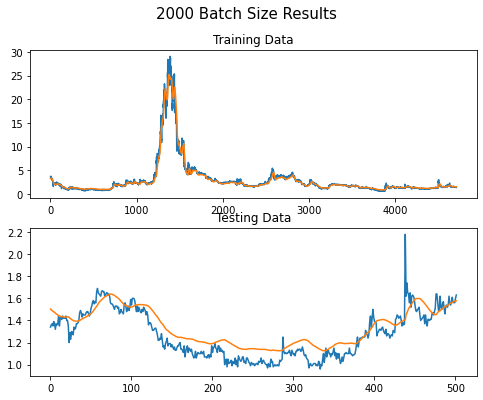

In [16]:
model = loadModel(name='fordBatchTraining2000')


# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('2000 Batch Size Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")

meanSquared, yHat, y = mse(xTest,yTest)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")

plt.show()

0.04886549015102097
0.004672110491505384


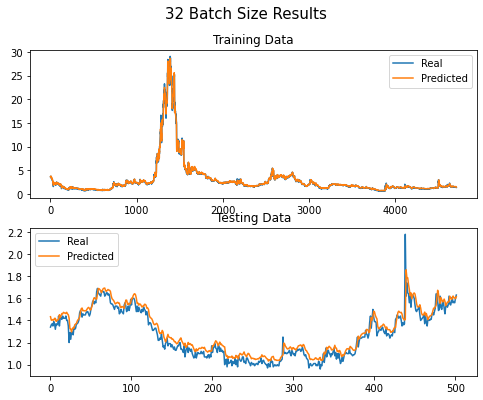

In [49]:
model = loadModel(name='fordBatchTraining32')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('32 Batch Size Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

## First Model
We have now transformed the data into the required format with both a training and testing.  So lets try fitting to a model!

In [16]:
# CITATION 1: https://www.youtube.com/watch?v=BSpXCRTOLJA
# CITATION 2: https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe
# Citation 1 was used as a starting point to get the model to make at least semi-accurate predictions.
with tf.device("gpu:0"):
    model = Sequential()
    model.add(LSTM(128,input_shape=(xTrain.shape[1],xTrain.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(64))
    model.add(Activation('sigmoid'))
    model.add(Dense(1))
    model.add(Activation('linear'))


    opt = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(optimizer=opt, loss='mse')
    model.fit(xTrain,yTrain, epochs=3000, batch_size=BATCH_SIZE)

    # serialize model to JSON
    model_json = model.to_json()
    with open("data/fordLSTM_50Epochs.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("data/fordLSTM_50Epochs.h5")
    print("Saved model to disk")

# CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# load json and create model
# json_file = open('data/fordLSTM_50Epochs.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# # load weights into new model
# model.load_weights("data/fordLSTM_50Epochs.h5")
# print("Loaded model from disk")



011
Epoch 2761/3000
4/4 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 2762/3000
4/4 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 2763/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 2764/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 2765/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 2766/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 2767/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 2768/3000
4/4 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 2769/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 2770/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 2771/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0013
Epoch 2772/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0016


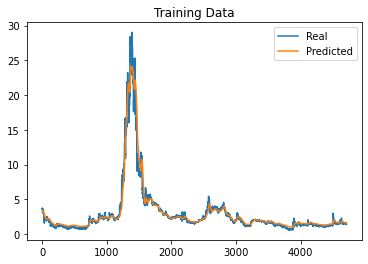

MSE: 0.5880039523969687


In [17]:
meanSquared, yHat, y = mse(xTrain,yTrain)
plot(yHat, y, 'Training Data')
print("MSE:",meanSquared)

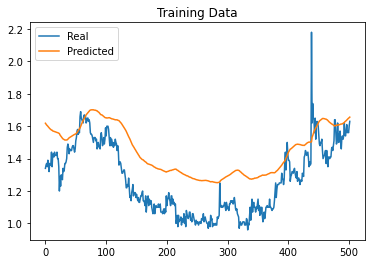

MSE: 0.042358694167463434


In [18]:
meanSquared, yHat, y = mse(xTest,yTest)
plot(yHat, y, 'Training Data')
print("MSE:",meanSquared)

We can see the results of our model above.  We can see our model begin to take the rough shape of the actual shape of the Test Data.  However, we need it to be far closer.  As we will see shortly, the model is in fact very undertrained.  To adjust for this, lets run the model on varying Epochs (i.e. how many times you run the data through to train the model).  We will test this on 50,100,500,1000, 2000, 2500 and 3000 epochs and record the MSE to give a rough evaluation of the models.  Note, the different epochs were chosen as a combination of both arbitrarilty and through trial and error.

## Model Tuning 1: Epochs

In [67]:
# def epochs(epoch):
#     with tf.device("gpu:0"):
#         model = Sequential()
#         model.add(LSTM(128,input_shape=(xTrain.shape[1],xTrain.shape[2])))
#         model.add(Dropout(0.2))
#         model.add(Dense(64))
#         model.add(Activation('sigmoid'))
#         model.add(Dense(1))
#         model.add(Activation('linear'))

#         opt = tf.keras.optimizers.Adam(lr=0.0005)
#         model.compile(optimizer=opt, loss='mse')
#         # model.fit(train_dataset, epochs=i,validation_data = test_dataset, use_multiprocessing=True, workers=8, batch_size=BATCH_SIZE)
#         model.fit(xTrain,yTrain, epochs=epoch, batch_size=BATCH_SIZE)
#         return model

# res = pd.DataFrame(columns=['epoch','mseTest','mseTrain'])
# for i in [50,100,500,1000,2000,2500,3000]:
#     model = epochs(i)
#     meanSquaredTest, yHat, y = mse(xTest,yTest)
#     meanSquaredTrain, yHat, y = mse(xTrain,yTrain)
#     res = res.append({'epoch':i,'mseTest':meanSquaredTest,'mseTrain':meanSquaredTrain},ignore_index=True)

#     # serialize model to JSON
#     model_json = model.to_json()
#     with open(f"data/fordLSTM_{i}Epochs.json", "w") as json_file:
#         json_file.write(model_json)
#     # serialize weights to HDF5
#     model.save_weights(f"data/fordLSTM_{i}Epochs.h5")
#     print("Saved model to disk")

# res.to_csv("epochResults.csv")
res = pd.read_csv("epochResults.csv")
res



,Unnamed: 0,epoch,mseTest,mseTrain
0,0,50.0,0.024447,5.165668
1,1,100.0,0.375613,2.023062
2,2,500.0,0.513497,3.257916
3,3,1000.0,0.172833,1.063658
4,4,2000.0,0.043386,0.876366
5,5,2500.0,0.015286,0.529018
6,6,3000.0,0.128612,1.625686


Above we see the results of training the model further.  We can clearly see that MSE decreases as we continue to train the model.  However, when we reach 3000 epochs the MSE of the Testing data begins to increase and the MSE of the Training Data begins to decrease.  Is is possible that we are overfitting the data at 3000 epochs.  Thus, we will use 2000 epochs in our model.  Below we vizualize the result of the 2500 epoch model.

In [36]:
# CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
json_file = open('data/fordLSTM_2500Epochs.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("data/fordLSTM_2500Epochs.h5")
print("Loaded model from disk") 


Loaded model from disk


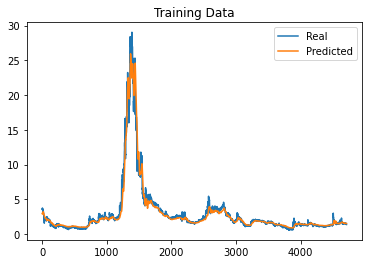

MSE: 0.5290175907305708


In [42]:
plot(yHat, y, 'Training Data')
meanSquared, yHat, y = mse(xTrain,yTrain)
print("MSE:",meanSquared)

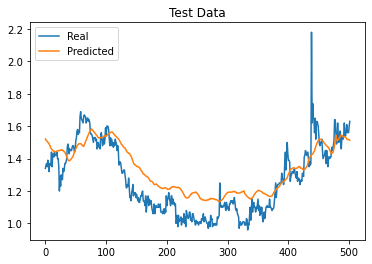

MSE: 0.01528621021655068


In [58]:
plot(yHat, y, 'Test Data')
meanSquared, yHat, y = mse(xTest,yTest)
print("MSE:",meanSquared)

Above are the plots of our test and training data.  The results appear to be significantly improved considering we have not done any formal tuning at this point.  Surprisingly, we can actually see that that model appears to perform better on the testing data than the training data.  We take this as an indication that the model does not appear to be over fitting the training data.  Thus, no further dropouts will be added to the model nor will any adjustments be made there.  However, we will continue to try and improve the model. 

Note, the reader may notice that the MSE of the 2000 epoch model displayed with their respective plots differs from the MSE of the 2000 epoch model displayed in the tabel above.  This is likely due to where the MSE's were computed.  While the code was the same, the MSE in the table above was computed on Google Colab while training the models and the MSE computed with the plots was done locally.  There is perhaps some difference of rounding.

In [ ]:
## Model Tuning 2: Learning Rate

Seeing as we will stick with an epoch of 2500.  Lets attempt to optimize the learning rate for this number of epochs.  We will use a log scale of 0.1,0.001,0.0001,0. 

## Model Tuning 2: Neurons
Lets now tune the number of hidden nodes contained in the LSTM layer.  Note, the original value of 128 was chosen arbitrarilty.  To test this, we will do so on a model with 500 epochs to minimize computation time.  Furthermore, not that the range of neurons chosen is in fact arbitraty.

In [ ]:
def epochs(neurons):
    with tf.device("gpu:0"):
        model = Sequential()
        model.add(LSTM(neurons,input_shape=(xTrain.shape[1],xTrain.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(64))
        model.add(Activation('sigmoid'))
        model.add(Dense(1))
        model.add(Activation('linear'))

        opt = tf.keras.optimizers.Adam(lr=0.0005)
        model.compile(optimizer=opt, loss='mse')
        model.fit(xTrain,yTrain, epochs=500, validation_data=(xTest,yTest))
        return model

res = pd.DataFrame(columns=['neurons','mseTest','mseTrain'])
for i in [50,70,90,100,120,140]:
    model = epochs(i)
    meanSquaredTest, yHat, y = mse(xTest,yTest)
    meanSquaredTrain, yHat, y = mse(xTrain,yTrain)
    res = res.append({'neurons':i,'mseTest':meanSquaredTest,'mseTrain':meanSquaredTrain},ignore_index=True)

      # serialize model to JSON
    model_json = model.to_json()
    with open(f"data/fordLSTM_{i}Neurons.json", "w") as json_file:
    json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"data/fordLSTM_{i}Neurons.h5")
    print("Saved model to disk")

res.to_csv("neuronResults.csv")


# res = pd.read_csv("epochResults.csv")
# res

In [42]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11836189200443633486
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6910041152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7473195948957447547
physical_device_desc: "device: 0, name: GeForce RTX 3070, pci bus id: 0000:2d:00.0, compute capability: 8.6"
]
